In [2]:
import pickle 
import numpy as np 
# import tensorflow as tf 
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.utils import shuffle
from sklearn.manifold import MDS
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import multivariate_normal
from scipy.stats import zscore
from scipy.spatial.distance import squareform,pdist
from scipy.linalg import expm 

### useful variables 


In [3]:

N_MODELS = 3
model_labels = ['grid','orthogonal','parallel']
N_RUNS = 10
N_HIDDEN = 100

def mse(y_,y):
    return .5*norm(y_-y,2)**2


r_n, r_s = np.meshgrid(np.linspace(-2, 2, 5),np.linspace(-2, 2, 5))
r_s = r_s.flatten()
r_n = r_n.flatten()
ylabels = np.concatenate((r_n,r_s),axis=0)[:,np.newaxis]

In [4]:
def plot_grid3(xyz,line_colour='green',line_width=2,fig_id=1):
    # %matplotlib qt    
    x,y = np.meshgrid(np.arange(0,5),np.arange(0,5))
    x = x.flatten()
    y = y.flatten()
    try: xyz 
    except NameError: xyz = np.stack((x,y,np.ones((25,))),axis=1)
    bl = np.stack((x,y),axis=1)
    plt.figure(fig_id)    
    ax = plt.gca()
    for ii in range(0,4):
        for jj in range(0,4):
            p1 = xyz[(bl[:,0]==ii) & (bl[:,1]==jj),:].ravel()
            p2 = xyz[(bl[:,0]==ii+1) & (bl[:,1]==jj),:].ravel()        
            plt.plot([p1[0],p2[0]],[p1[1],p2[1]],[p1[2],p2[2]],linewidth=line_width,color=line_colour)
            p2 = xyz[(bl[:,0]==ii) & (bl[:,1]==jj+1),:].ravel()
            plt.plot([p1[0],p2[0]],[p1[1],p2[1]],[p1[2],p2[2]],linewidth=line_width,color=line_colour)
    ii = 4
    for jj in range(0,4):
        p1 = xyz[(bl[:,0]==ii) & (bl[:,1]==jj),:].ravel()
        p2 = xyz[(bl[:,0]==ii) & (bl[:,1]==jj+1),:].ravel()
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]],[p1[2],p2[2]],linewidth=line_width,color=line_colour)

    jj = 4
    for ii in range(0,4):
        p1 = xyz[(bl[:,0]==ii) & (bl[:,1]==jj),:].ravel()
        p2 = xyz[(bl[:,0]==ii+1) & (bl[:,1]==jj),:].ravel()
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]],[p1[2],p2[2]],linewidth=line_width,color=line_colour)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-2,2])

def plot_grid2(xy,line_colour='green',line_width=2,fig_id=1):
    # %matplotlib qt    
    x,y = np.meshgrid(np.arange(0,5),np.arange(0,5))
    x = x.flatten()
    y = y.flatten()    
    try: xy 
    except NameError: xy = np.stack((x,y),axis=1)
    bl = np.stack((x,y),axis=1)
    fig = plt.figure(fig_id)
    
    for ii in range(0,4):
        for jj in range(0,4):
            p1 = xy[(bl[:,0]==ii) & (bl[:,1]==jj),:].ravel()
            p2 = xy[(bl[:,0]==ii+1) & (bl[:,1]==jj),:].ravel()        
            plt.plot([p1[0],p2[0]],[p1[1],p2[1]],linewidth=line_width,color=line_colour)
            p2 = xy[(bl[:,0]==ii) & (bl[:,1]==jj+1),:].ravel()
            plt.plot([p1[0],p2[0]],[p1[1],p2[1]],linewidth=line_width,color=line_colour)
    ii = 4
    for jj in range(0,4):
        p1 = xy[(bl[:,0]==ii) & (bl[:,1]==jj),:].ravel()
        p2 = xy[(bl[:,0]==ii) & (bl[:,1]==jj+1),:].ravel()
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]],linewidth=line_width,color=line_colour)

    jj = 4
    for ii in range(0,4):
        p1 = xy[(bl[:,0]==ii) & (bl[:,1]==jj),:].ravel()
        p2 = xy[(bl[:,0]==ii+1) & (bl[:,1]==jj),:].ravel()
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]],linewidth=line_width,color=line_colour)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])  
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    


def scatter_mds_3(xyz,task_id='a',fig_id=1):
    if task_id=='both':
        n_items = 50
        ctxMarkerEdgeCol = [(0,0,.5),'orange']
    elif task_id=='a':
        n_items = 25
        ctxMarkerEdgeCol = (0,0,.5)
    elif task_id=='b':
        ctxMarkerEdgeCol = 'orange'
    elif task_id == 'avg':
        ctxMarkerEdgeCol = None

    ctxMarkerCol = 'white'
    ctxMarkerSize = 20
    itemMarkerSize = 2
    scat_b = np.arange(5,15,2)
    # scat_l = np.array([[50, 56, 168], [118, 46, 166], [158, 47, 168], [161, 43, 120], [176, 40, 65]])/255
    scat_l = np.array([[3,252,82], [3,252,177], [3,240,252], [3,152,252], [3,73,252]])/255

    b,l = np.meshgrid(np.arange(0,5),np.arange(0,5))
    b = b.flatten()
    l = l.flatten()   
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    
    
    fig = plt.figure(fig_id)
    ax = plt.gca()
    if task_id == 'both':
        b = np.concatenate((b,b),axis=0)
        l = np.concatenate((l,l),axis=0)
        
        for ii in range(0,n_items//2):
            
            plt.plot([x[ii],x[ii]],[y[ii],y[ii]],[z[ii],z[ii]],marker='s',markerfacecolor=ctxMarkerCol,markeredgecolor=ctxMarkerEdgeCol[0],markersize=ctxMarkerSize,markeredgewidth=2)
            plt.plot([x[ii],x[ii]],[y[ii],y[ii]],[z[ii],z[ii]],marker='h',markeredgecolor=scat_l[l[ii],:],markerfacecolor=scat_l[l[ii],:],markersize=scat_b[b[ii]])
        for ii in range(n_items//2,n_items):
            
            plt.plot([x[ii],x[ii]],[y[ii],y[ii]],[z[ii],z[ii]],marker='s',markerfacecolor=ctxMarkerCol,markeredgecolor=ctxMarkerEdgeCol[1],markersize=ctxMarkerSize,markeredgewidth=2)
            plt.plot([x[ii],x[ii]],[y[ii],y[ii]],[z[ii],z[ii]],marker='h',markeredgecolor=scat_l[l[ii],:],markerfacecolor=scat_l[l[ii],:],markersize=scat_b[b[ii]])
    else:
        for ii in range(0,n_items):
            
            plt.plot([x[ii],x[ii]],[y[ii],y[ii]],[z[ii],z[ii]],marker='s',markerfacecolor=ctxMarkerCol,markeredgecolor=ctxMarkerEdgeCol,markersize=ctxMarkerSize,markeredgewidth=2)
            plt.plot([x[ii],x[ii]],[y[ii],y[ii]],[z[ii],z[ii]],marker='h',markeredgecolor=scat_l[l[ii],:],markerfacecolor=scat_l[l[ii],:],markersize=scat_b[b[ii]])




def scatter_mds_2(xyz,task_id='a',fig_id=1):
    if task_id=='both':
        n_items = 50
        ctxMarkerEdgeCol = [(0,0,.5),'orange']
    elif task_id=='a':
        n_items = 25
        ctxMarkerEdgeCol = (0,0,.5)
    elif task_id=='b':
        ctxMarkerEdgeCol = 'orange'
    elif task_id == 'avg':
        ctxMarkerEdgeCol = None

    ctxMarkerCol = 'white'
    ctxMarkerSize = 20
    itemMarkerSize = 2
    scat_b = np.arange(10,20,2)
    scat_l = np.array([[3,252,82], [3,252,177], [3,240,252], [3,152,252], [3,73,252]])/255

    b,l = np.meshgrid(np.arange(0,5),np.arange(0,5))
    b = b.flatten()
    l = l.flatten()   
    x = xyz[:,0]
    y = xyz[:,1]
    
    

    if task_id == 'both':
        b = np.concatenate((b,b),axis=0)
        l = np.concatenate((l,l),axis=0)
        fig = plt.figure(fig_id)
        for ii in range(0,n_items//2):
            
            plot(x[ii],y[ii],marker='s',markerfacecolor=ctxMarkerCol,markeredgecolor=ctxMarkerEdgeCol[0,:],markersize=ctxMarkerSize,markeredgewidth=2)
            plt.plot(x[ii],y[ii],marker='h',markeredgecolor=scat_l[l[ii],:],markerfacecolor=scat_l[l[ii],:],markersize=scat_b[b[ii]])
        for ii in range(n_items//2,n_items):
            
            plt.plot(x[ii],y[ii],marker='s',markerfacecolor=ctxMarkerCol,markeredgecolor=ctxMarkerEdgeCol[1,:],markersize=ctxMarkerSize,markeredgewidth=2)
            plt.plot(x[ii],y[ii],marker='h',markeredgecolor=scat_l[l[ii],:],markerfacecolor=scat_l[l[ii],:],markersize=scat_b[b[ii]])
    else:
        for ii in range(0,n_items):
            
            plt.plot(x[ii],y[ii],marker='s',markerfacecolor=ctxMarkerCol,markeredgecolor=ctxMarkerEdgeCol,markersize=ctxMarkerSize,markeredgewidth=2)
            plt.plot(x[ii],y[ii],marker='h',markeredgecolor=scat_l[l[ii],:],markerfacecolor=scat_l[l[ii],:],markersize=scat_b[b[ii]])

def plot_mds(xyz,ndims=2,fig_id=1):

    if ndims==3:
        fig = plt.figure(fig_id)
        ax = fig.add_subplot(111,projection='3d')
        plot_grid3(data[0:25,:],line_colour=(0, 0, .5),fig_id=fig_id)
        plot_grid3(data[25:,:],line_colour='orange',fig_id=fig_id)
        scatter_mds_3(data,fig_id=2,task_id='both')
        
    elif ndims==2:
        fig = plt.figure(fig_id)
        plot_grid2(data[0:25,:],line_colour=(0, 0, .5),fig_id=fig_id)
        plot_grid2(data[25:,:],line_colour='orange',fig_id=fig_id)
        scatter_mds_2(data,fig_id=2,task_id='both')
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([]) 
    plt.show()

In [5]:
ctxMarkerEdgeCol = [(0,0,.5),'orange']
ctxMarkerEdgeCol[0]

(0, 0, 0.5)

## Experiment 2: SGD with RDM Loss funct.

In [7]:
%matplotlib qt

In [6]:
with open('data_final/final_blob_mlp_1h_baseline.pickle','rb') as f:
    results_baseline = pickle.load(f)
with open('data_final/final_blob_mlp_1h_rdm.pickle','rb') as f:
    results_rdm = pickle.load(f)


### MSE and Accuracy (Endpoint)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (3).

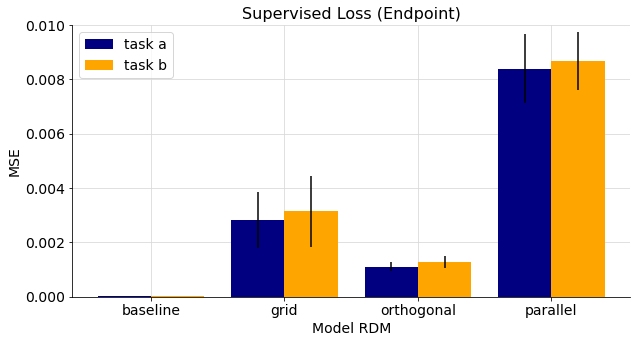

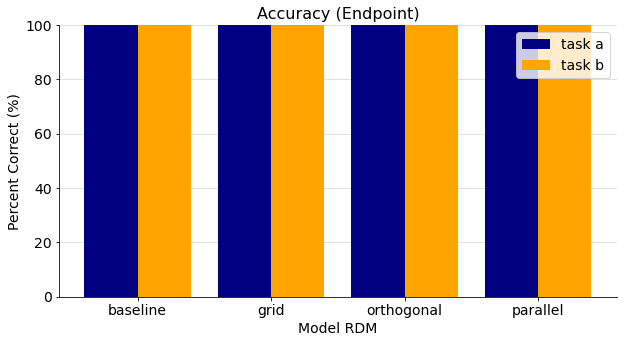

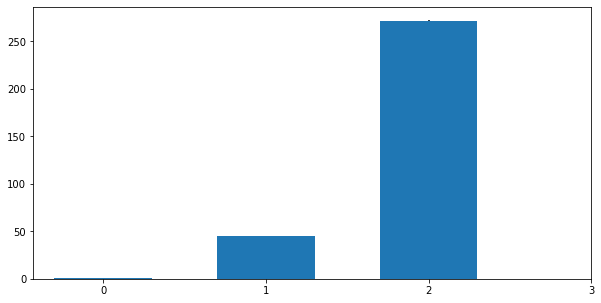

In [7]:
def compute_acc(y_,y):
    return np.mean((y_>.1) == (y>.1))
xlabels = ['baseline'] + model_labels
# ---------------------------------------------------
# Endpoint training MSE (each task)
# x axis: model (baseline, grid, ...)
# y axis: one bar per task
mse_vals_a = np.empty((N_MODELS+1,10))
mse_vals_b = np.empty((N_MODELS+1,10))
# baseline 
for ii in range(0,N_RUNS):
    mse_vals_a[0,ii] = mse(results_baseline['all_y_out'][0,ii,0,0:25][:,np.newaxis],ylabels[0:25])
    mse_vals_b[0,ii] = mse(results_baseline['all_y_out'][0,ii,0,25:][:,np.newaxis],ylabels[25:])

for ii in range(0,N_MODELS):
    for jj in range(0,10):
        mse_vals_a[ii+1,jj] = mse(results_rdm['all_y_out'][ii,jj,0,0:25][:,np.newaxis],ylabels[0:25])
        mse_vals_b[ii+1,jj] = mse(results_rdm['all_y_out'][ii,jj,0,25:][:,np.newaxis],ylabels[25:])

plt.close(2)
plt.figure(2,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS+1)-.2,np.mean(mse_vals_a,1),width=0.4,yerr=np.std(mse_vals_a,1)/np.sqrt(N_RUNS),color=(0,0,.5),zorder=3)
plt.bar(np.arange(0,N_MODELS+1)+.2,np.mean(mse_vals_b,1),width=0.4,yerr=np.std(mse_vals_b,1)/np.sqrt(N_RUNS),color='orange',zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS+1),labels=xlabels,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['task a', 'task b'],fontsize=14)
plt.title('Supervised Loss (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f = plt.gcf()
ax.set_ylim([0,0.01])
f.set_size = (10,5)
# f.get_figwidth()
# f.get_figheight()
# Endpoint training accuracy (each task)
acc_vals_a = np.empty((N_MODELS+1,10))
acc_vals_b = np.empty((N_MODELS+1,10))
for ii in range(0,N_RUNS):
    acc_vals_a[0,ii] = compute_acc(results_baseline['all_y_out'][0,ii,0,0:25][:,np.newaxis],ylabels[0:25])
    acc_vals_b[0,ii] = compute_acc(results_baseline['all_y_out'][0,ii,0,25:][:,np.newaxis],ylabels[25:])

for ii in range(0,N_MODELS):
    for jj in range(0,10):
        acc_vals_a[ii+1,jj] = compute_acc(results_rdm['all_y_out'][ii,jj,0,0:25][:,np.newaxis],ylabels[0:25])
        acc_vals_b[ii+1,jj] = compute_acc(results_rdm['all_y_out'][ii,jj,0,25:][:,np.newaxis],ylabels[25:])
plt.close(3)
plt.figure(3,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS+1)-.2,np.mean(acc_vals_a,1),width=0.4,yerr=np.std(acc_vals_a,1)/np.sqrt(N_RUNS),color=(0,0,.5),zorder=3)
plt.bar(np.arange(0,N_MODELS+1)+.2,np.mean(acc_vals_b,1),width=0.4,yerr=np.std(acc_vals_b,1)/np.sqrt(N_RUNS),color='orange',zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS+1),labels=xlabels,fontsize=14)
plt.yticks(ticks=plt.yticks()[0],labels=[int(ii) for ii in plt.yticks()[0]*100],fontsize=14)
plt.ylim((0,1))
plt.legend(['task a', 'task b'],fontsize=14)
plt.title('Accuracy (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('Percent Correct (%)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig = plt.gcf()
fig.set_size = (10,5)

# rdm loss 
plt.close(4)
plt.figure(4,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS),np.mean(results_rdm['losses_rdm'][:,:,-1],1),yerr=np.std(results_rdm['losses_rdm'][:,:,-1],1)/np.sqrt(N_RUNS),width=0.6,zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS+1),labels=model_labels,fontsize=14)
plt.yticks(fontsize=14)
plt.title('RDM Loss (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Fraction of Task-specific Units

In [8]:
coeffs_mu_a = np.concatenate((np.mean(results_baseline['n_only_a'][:,:,1],1)/N_HIDDEN,np.mean(results_rdm['n_only_a'][:,:,1],1)/N_HIDDEN),axis=0)


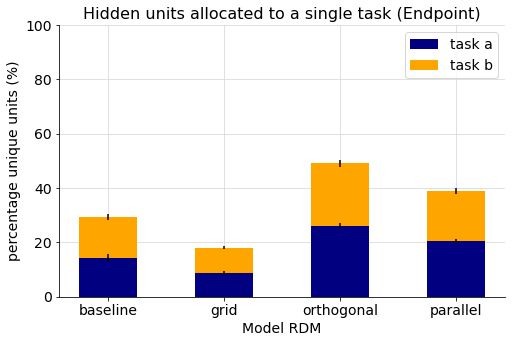

In [9]:
# Sparsity of hidden layer - endpoint
xlabels = ['baseline'] + model_labels
plt.figure(figsize=(8,5))
# task A and b units
coeffs_mu_a = np.concatenate((np.mean(results_baseline['n_only_a'][:,:,1],1)/N_HIDDEN,np.mean(results_rdm['n_only_a'][:,:,1],1)/N_HIDDEN),axis=0)
coeffs_err_a = np.concatenate((np.std(results_baseline['n_only_a'][:,:,1],1)/np.sqrt(results_baseline['n_only_a'][:,:,1].shape[1]),np.std(results_rdm['n_only_a'][:,:,1],1)/np.sqrt(results_rdm['n_only_a'][:,:,1].shape[1])),axis=0)
coeffs_err_a /= np.asarray(N_HIDDEN)
ha = plt.bar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,width=0.5,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,fmt='.')

coeffs_mu_b = np.concatenate((np.mean(results_baseline['n_only_b'][:,:,1],1)/N_HIDDEN,np.mean(results_rdm['n_only_b'][:,:,1],1)/N_HIDDEN),axis=0)
coeffs_err_b = np.concatenate((np.std(results_baseline['n_only_b'][:,:,1],1)/np.sqrt(results_baseline['n_only_b'][:,:,1].shape[1]),np.std(results_rdm['n_only_b'][:,:,1],1)/np.sqrt(results_rdm['n_only_b'][:,:,1].shape[1])),axis=0)
coeffs_err_b /= np.asarray(N_HIDDEN)
hb = plt.bar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',bottom=coeffs_mu_a,width=0.5,yerr=coeffs_err_b,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',yerr=coeffs_err_b,fmt='.')
plt.legend([ha,hb],['task a', 'task b'],fontsize=14)
plt.ylim([0,1])
# plt.plot(plt.xlim(),[0.5,0.5],'--')
plt.yticks(ticks=tuple(plt.yticks()[0]),labels=tuple((plt.yticks()[0]*100).astype('int')),fontsize=14)
plt.xticks(ticks=np.arange(0,coeffs_mu_a.shape[0]),labels=xlabels,fontsize=14)
plt.ylabel('percentage unique units (%)',fontsize=14)
plt.xlabel('Model RDM',fontsize=14)
# plt.xticks(np.arange(0,len(N_HIDDEN)+1),N_HIDDEN)
plt.title('Hidden units allocated to a single task (Endpoint)',fontsize=16)
# plt.box(on=False)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



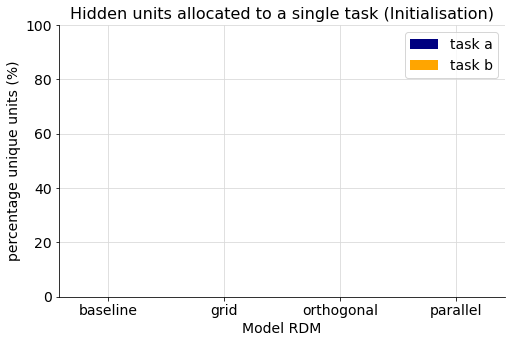

In [10]:
# Sparsity of hidden layer - initialisation
xlabels = ['baseline'] + model_labels
plt.figure(figsize=(8,5))
# task A and b units
coeffs_mu_a = np.concatenate((np.mean(results_baseline['n_only_a'][:,:,0],1)/N_HIDDEN,np.mean(results_rdm['n_only_a'][:,:,0],1)/N_HIDDEN),axis=0)
coeffs_err_a = np.concatenate((np.std(results_baseline['n_only_a'][:,:,0],1)/np.sqrt(results_baseline['n_only_a'][:,:,0].shape[1]),np.std(results_rdm['n_only_a'][:,:,0],1)/np.sqrt(results_rdm['n_only_a'][:,:,0].shape[1])),axis=0)
coeffs_err_a /= np.asarray(N_HIDDEN)
ha = plt.bar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,width=0.5,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,fmt='.')

coeffs_mu_b = np.concatenate((np.mean(results_baseline['n_only_b'][:,:,0],1)/N_HIDDEN,np.mean(results_rdm['n_only_b'][:,:,0],1)/N_HIDDEN),axis=0)
coeffs_err_b = np.concatenate((np.std(results_baseline['n_only_b'][:,:,0],1)/np.sqrt(results_baseline['n_only_b'][:,:,0].shape[1]),np.std(results_rdm['n_only_b'][:,:,0],1)/np.sqrt(results_rdm['n_only_b'][:,:,0].shape[1])),axis=0)
coeffs_err_b /= np.asarray(N_HIDDEN)
hb = plt.bar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',bottom=coeffs_mu_a,width=0.5,yerr=coeffs_err_b,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',yerr=coeffs_err_b,fmt='.')
plt.legend([ha,hb],['task a', 'task b'],fontsize=14)
plt.ylim([0,1])
# plt.plot(plt.xlim(),[0.5,0.5],'--')
plt.yticks(ticks=tuple(plt.yticks()[0]),labels=tuple((plt.yticks()[0]*100).astype('int')),fontsize=14)
plt.xticks(ticks=np.arange(0,coeffs_mu_a.shape[0]),labels=xlabels,fontsize=14)
plt.ylabel('percentage unique units (%)',fontsize=14)
plt.xlabel('Model RDM',fontsize=14)
# plt.xticks(np.arange(0,len(N_HIDDEN)+1),N_HIDDEN)
plt.title('Hidden units allocated to a single task (Initialisation)',fontsize=16)
# plt.box(on=False)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


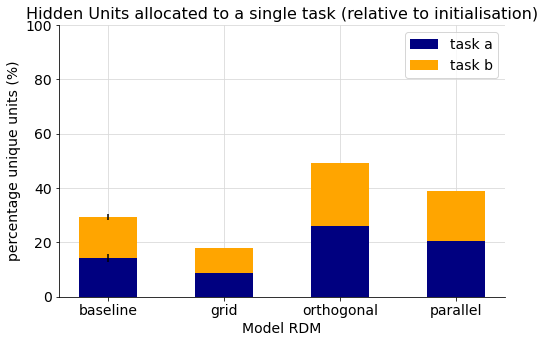

In [11]:
# Sparsity of hidden layer - relative difference
xlabels = ['baseline'] + model_labels
plt.figure(figsize=(8,5))
# task A and b units
coeffs_mu_a_ep = np.concatenate((np.mean(results_baseline['n_only_a'][:,:,1],1)/N_HIDDEN,np.mean(results_rdm['n_only_a'][:,:,1],1)/N_HIDDEN),axis=0)
coeffs_err_a_ep = np.concatenate((np.std(results_baseline['n_only_a'][:,:,1],1)/np.sqrt(results_baseline['n_only_a'][:,:,1].shape[1]),np.std(results_rdm['n_only_a'][:,:,1],1)/np.sqrt(results_rdm['n_only_a'][:,:,1].shape[1])),axis=0)
coeffs_err_a_ep /= np.asarray(N_HIDDEN)
coeffs_mu_a_init = np.concatenate((np.mean(results_baseline['n_only_a'][:,:,0],1)/N_HIDDEN,np.mean(results_rdm['n_only_a'][:,:,0],1)/N_HIDDEN),axis=0)
coeffs_err_a_init = np.concatenate((np.std(results_baseline['n_only_a'][:,:,0],1)/np.sqrt(results_baseline['n_only_a'][:,:,0].shape[1]),np.std(results_rdm['n_only_a'][:,:,1],1)/np.sqrt(results_rdm['n_only_a'][:,:,1].shape[1])),axis=0)
coeffs_err_a_init /= np.asarray(N_HIDDEN)

coeffs_mu_a = coeffs_mu_a_ep-coeffs_mu_a_init
coeffs_err_a = coeffs_err_a_ep-coeffs_err_a_init

ha = plt.bar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,width=0.5,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,fmt='.')

coeffs_mu_b_ep = np.concatenate((np.mean(results_baseline['n_only_b'][:,:,1],1)/N_HIDDEN,np.mean(results_rdm['n_only_b'][:,:,1],1)/N_HIDDEN),axis=0)
coeffs_err_b_ep = np.concatenate((np.std(results_baseline['n_only_b'][:,:,1],1)/np.sqrt(results_baseline['n_only_b'][:,:,1].shape[1]),np.std(results_rdm['n_only_b'][:,:,1],1)/np.sqrt(results_rdm['n_only_b'][:,:,1].shape[1])),axis=0)
coeffs_err_b_ep /= np.asarray(N_HIDDEN)
coeffs_mu_b_init = np.concatenate((np.mean(results_baseline['n_only_b'][:,:,0],1)/N_HIDDEN,np.mean(results_rdm['n_only_b'][:,:,0],1)/N_HIDDEN),axis=0)
coeffs_err_b_init = np.concatenate((np.std(results_baseline['n_only_b'][:,:,0],1)/np.sqrt(results_baseline['n_only_b'][:,:,0].shape[1]),np.std(results_rdm['n_only_b'][:,:,1],1)/np.sqrt(results_rdm['n_only_b'][:,:,1].shape[1])),axis=0)
coeffs_err_b_init /= np.asarray(N_HIDDEN)

coeffs_mu_b = coeffs_mu_b_ep-coeffs_mu_b_init
coeffs_err_b = coeffs_err_b_ep-coeffs_err_b_init
hb = plt.bar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',bottom=coeffs_mu_a,width=0.5,yerr=coeffs_err_b,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',yerr=coeffs_err_b,fmt='.')
plt.legend([ha,hb],['task a', 'task b'],fontsize=14)
plt.ylim([0,1])
# plt.plot(plt.xlim(),[0.5,0.5],'--')
plt.yticks(ticks=tuple(plt.yticks()[0]),labels=tuple((plt.yticks()[0]*100).astype('int')),fontsize=14)
plt.xticks(ticks=np.arange(0,coeffs_mu_a.shape[0]),labels=xlabels,fontsize=14)
plt.ylabel('percentage unique units (%)',fontsize=14)
plt.xlabel('Model RDM',fontsize=14)
# plt.xticks(np.arange(0,len(N_HIDDEN)+1),N_HIDDEN)
plt.title('Hidden Units allocated to a single task (relative to initialisation)',fontsize=16)
# plt.box(on=False)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


### RSA: Model RDMS

In [12]:

def gen_modelrdms(monitor=0):
    ## model rdms:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    # grid model
    gridm = np.concatenate((a.flatten()[np.newaxis,:],b.flatten()[np.newaxis,:]),axis=0).T
    ctx = np.concatenate((np.ones((25,1)),0*np.ones((25,1))),axis=0).reshape(50,1)
    gridm = np.concatenate((np.tile(gridm,(2,1)),ctx),axis=1)
    grid_rdm = squareform(pdist(gridm,metric='euclidean'))


    # orthogonal model
    orthm = np.concatenate((np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0).T,
                            np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    orthm = np.concatenate((orthm,ctx),axis=1)
    orth_rdm = squareform(pdist(orthm,metric='euclidean'))


    # parallel model 
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    # parm = np.concatenate((R.dot(np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0)).T,
                            # np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    a = a.flatten()
    b = b.flatten()

    ta = np.stack((a,np.zeros((25))),axis=1)
    tb = np.stack((np.zeros(25),b),axis=1)
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    parm = np.concatenate((ta.dot(R),tb),axis=0)
    parm = np.concatenate((parm,ctx),axis=1)
    par_rdm = squareform(pdist(parm,metric='euclidean'))
    
    dmat = np.asarray([zscore(grid_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(orth_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(par_rdm[np.tril_indices(50,k=-1)].flatten())]).T
    rdms = np.empty((3,50,50))
    data_orig = np.empty((3,50,3))
    rdms[0] = grid_rdm
    rdms[1] = orth_rdm
    rdms[2] = par_rdm
    data_orig[0,:,:] = gridm 
    data_orig[1,:,:] = orthm 
    data_orig[2,:,:] = parm

    if monitor:
        fig=plt.figure(1,figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
        
        labels = ['grid model', 'orthogonal model', 'parallel model']
        for ii in range(3):
            plt.subplot(2,3,ii+1)
            plt.imshow(rdms[ii])
            plt.title(labels[ii])
        for ii in range(3,6):
            ax = fig.add_subplot(2,3,ii+1,projection='3d')
            embedding = MDS(n_components=3,n_init=10,max_iter=1000)
            xyz = data_orig[ii-3]#embedding.fit_transform(data_orig[ii-3])
                  
            plot_grid3(xyz[0:25,:],line_colour=(0, 0, .5),fig_id=1)
            plot_grid3(xyz[25:,:],line_colour='orange',fig_id=1)
            scatter_mds_3(xyz,fig_id=1,task_id='both')
            
            plt.title(labels[ii-3])

    return rdms,dmat,data_orig


def stats_fit_rdms(dmat,mlp_outputs):
    # stats 

    regr = linear_model.LinearRegression()
    n_runs = mlp_outputs.shape[1]
    n_factors  =mlp_outputs.shape[0]

    coeffs = np.empty((n_factors,n_runs,3))
    # loop through scaling factors 
    for ii in range(n_factors):
        for jj in range(n_runs):
            rdm = squareform(pdist(mlp_outputs[ii,jj,:,:].T,metric='euclidean'))
            y  = zscore(rdm[np.tril_indices(50,k=-1)].flatten())
            regr.fit(dmat,y)
            coeffs[ii,jj,:] = np.asarray(regr.coef_)

    return coeffs


%matplotlib qt
xlabels = ['baseline'] + model_labels
# generate design matrix
_, dmat,xyz = gen_modelrdms(monitor=1)
# concatenate baseline and rdm patterns and run RSA 
mlp_outputs = np.concatenate((results_baseline['all_y_hidden'],results_rdm['all_y_hidden']),axis=0)
coeffs = stats_fit_rdms(dmat,mlp_outputs)
# plot results (coefficients)
coeffs_mu = np.mean(coeffs,1)
coeffs_err = np.std(coeffs,1)/np.sqrt(N_RUNS)
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(0,coeffs_mu.shape[0])-0.25,coeffs_mu[:,0],yerr=coeffs_err[:,0],width=0.2,color='red',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0]),coeffs_mu[:,1],yerr=coeffs_err[:,1],width=0.2,color='green',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0])+0.25,coeffs_mu[:,2],yerr=coeffs_err[:,2],width=0.2,color='blue',zorder=3)
plt.legend(['grid rdm', 'orthogonal rdm', 'parallel rdm'],fontsize=14)
plt.xticks(np.arange(0,4),labels=xlabels,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Neural Network',fontsize=14)
plt.ylabel('parameter estimate (a.u.)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
plt.title('Model RSA',fontsize=16)
plt.ylim([0,1])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# visualise hidden layer patterns (RDMs and MDS)
y = np.concatenate((results_baseline['all_y_hidden'],results_rdm['all_y_hidden']),axis=0)
rdms = np.empty((y.shape[0],N_RUNS,50,50))
for ii in range(rdms.shape[0]):
    for jj in range(N_RUNS):
        rdms[ii,jj,:,:] = squareform(pdist(y[ii,jj,:,:].T,metric='euclidean'))



fig=plt.figure(3,figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(rdms.shape[0]):
    plt.subplot(1,rdms.shape[0],ii+1)
    plt.imshow(np.mean(rdms[ii,:,:,:],0))
    plt.title(xlabels[ii])

fig=plt.figure(4,figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(rdms.shape[0]):
    ax = fig.add_subplot(1,rdms.shape[0],ii+1,projection='3d')
    embedding = MDS(n_components=3,n_init=10,max_iter=1000)
    xyz = embedding.fit_transform(np.mean(rdms[ii,:,:,:],0))
            
    plot_grid3(xyz[0:25,:],line_colour=(0, 0, .5),fig_id=4)
    plot_grid3(xyz[25:,:],line_colour='orange',fig_id=4)
    scatter_mds_3(xyz,fig_id=4,task_id='both')    
    plt.title(xlabels[ii])
    ax = plt.gca()
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_zlim([-5,5])


C:\Users\Timo\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\Timo\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\Timo\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\Timo\anaconda3\e

## .. same story with two hidden layers

In [13]:
with open('data_final/final_blob_mlp_2h_baseline.pickle','rb') as f:
    results_baseline = pickle.load(f)
with open('data_final/final_blob_mlp_2h_rdm.pickle','rb') as f:
    results_rdm = pickle.load(f)


In [14]:
def compute_acc(y_,y):
    return np.mean((y_>.1) == (y>.1))
xlabels = ['baseline'] + model_labels
# ---------------------------------------------------
# Endpoint training MSE (each task)
# x axis: model (baseline, grid, ...)
# y axis: one bar per task
mse_vals_a = np.empty((N_MODELS+1,10))
mse_vals_b = np.empty((N_MODELS+1,10))
# baseline 
for ii in range(0,N_RUNS):
    mse_vals_a[0,ii] = mse(results_baseline['all_y_out'][0,ii,0,0:25][:,np.newaxis],ylabels[0:25])
    mse_vals_b[0,ii] = mse(results_baseline['all_y_out'][0,ii,0,25:][:,np.newaxis],ylabels[25:])

for ii in range(0,N_MODELS):
    for jj in range(0,10):
        mse_vals_a[ii+1,jj] = mse(results_rdm['all_y_out'][ii,jj,0,0:25][:,np.newaxis],ylabels[0:25])
        mse_vals_b[ii+1,jj] = mse(results_rdm['all_y_out'][ii,jj,0,25:][:,np.newaxis],ylabels[25:])

plt.close(2)
plt.figure(2,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS+1)-.2,np.mean(mse_vals_a,1),width=0.4,yerr=np.std(mse_vals_a,1)/np.sqrt(N_RUNS),color=(0,0,.5),zorder=3)
plt.bar(np.arange(0,N_MODELS+1)+.2,np.mean(mse_vals_b,1),width=0.4,yerr=np.std(mse_vals_b,1)/np.sqrt(N_RUNS),color='orange',zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS+1),labels=xlabels,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['task a', 'task b'],fontsize=14)
plt.title('Supervised Loss (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f = plt.gcf()
ax.set_ylim([0,0.01])
f.set_size = (10,5)
# f.get_figwidth()
# f.get_figheight()
# Endpoint training accuracy (each task)
acc_vals_a = np.empty((N_MODELS+1,10))
acc_vals_b = np.empty((N_MODELS+1,10))
for ii in range(0,N_RUNS):
    acc_vals_a[0,ii] = compute_acc(results_baseline['all_y_out'][0,ii,0,0:25][:,np.newaxis],ylabels[0:25])
    acc_vals_b[0,ii] = compute_acc(results_baseline['all_y_out'][0,ii,0,25:][:,np.newaxis],ylabels[25:])

for ii in range(0,N_MODELS):
    for jj in range(0,10):
        acc_vals_a[ii+1,jj] = compute_acc(results_rdm['all_y_out'][ii,jj,0,0:25][:,np.newaxis],ylabels[0:25])
        acc_vals_b[ii+1,jj] = compute_acc(results_rdm['all_y_out'][ii,jj,0,25:][:,np.newaxis],ylabels[25:])
plt.close(3)
plt.figure(3,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS+1)-.2,np.mean(acc_vals_a,1),width=0.4,yerr=np.std(acc_vals_a,1)/np.sqrt(N_RUNS),color=(0,0,.5),zorder=3)
plt.bar(np.arange(0,N_MODELS+1)+.2,np.mean(acc_vals_b,1),width=0.4,yerr=np.std(acc_vals_b,1)/np.sqrt(N_RUNS),color='orange',zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS+1),labels=xlabels,fontsize=14)
plt.yticks(ticks=plt.yticks()[0],labels=[int(ii) for ii in plt.yticks()[0]*100],fontsize=14)
plt.ylim((0,1))
plt.legend(['task a', 'task b'],fontsize=14)
plt.title('Accuracy (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('Percent Correct (%)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig = plt.gcf()
fig.set_size = (10,5)

# rdm loss 
plt.close(4)
plt.figure(4,figsize=(10,5))
plt.bar(np.arange(0,N_MODELS),np.mean(results_rdm['losses_rdm'][:,:,-1],1),yerr=np.std(results_rdm['losses_rdm'][:,:,-1],1)/np.sqrt(N_RUNS),width=0.6,zorder=3)
plt.xticks(ticks=np.arange(0,N_MODELS+1),labels=model_labels,fontsize=14)
plt.yticks(fontsize=14)
plt.title('RDM Loss (Endpoint)',fontsize=16)
plt.xlabel('Model RDM',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (3).

In [15]:
# Sparsity of hidden layer - endpoint
xlabels = ['baseline'] + model_labels
plt.figure(figsize=(8,5))
# task A and b units
coeffs_mu_a = np.concatenate((np.mean(results_baseline['n_only_a1'][:,:,1],1)/N_HIDDEN,np.mean(results_rdm['n_only_a1'][:,:,1],1)/N_HIDDEN),axis=0)
coeffs_err_a = np.concatenate((np.std(results_baseline['n_only_a1'][:,:,1],1)/np.sqrt(results_baseline['n_only_a1'][:,:,1].shape[1]),np.std(results_rdm['n_only_a1'][:,:,1],1)/np.sqrt(results_rdm['n_only_a1'][:,:,1].shape[1])),axis=0)
coeffs_err_a /= np.asarray(N_HIDDEN)
ha = plt.bar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,width=0.5,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,fmt='.')

coeffs_mu_b = np.concatenate((np.mean(results_baseline['n_only_b1'][:,:,1],1)/N_HIDDEN,np.mean(results_rdm['n_only_b1'][:,:,1],1)/N_HIDDEN),axis=0)
coeffs_err_b = np.concatenate((np.std(results_baseline['n_only_b1'][:,:,1],1)/np.sqrt(results_baseline['n_only_b1'][:,:,1].shape[1]),np.std(results_rdm['n_only_b1'][:,:,1],1)/np.sqrt(results_rdm['n_only_b1'][:,:,1].shape[1])),axis=0)
coeffs_err_b /= np.asarray(N_HIDDEN)
hb = plt.bar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',bottom=coeffs_mu_a,width=0.5,yerr=coeffs_err_b,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',yerr=coeffs_err_b,fmt='.')
plt.legend([ha,hb],['task a', 'task b'],fontsize=14)
plt.ylim([0,1])
# plt.plot(plt.xlim(),[0.5,0.5],'--')
plt.yticks(ticks=tuple(plt.yticks()[0]),labels=tuple((plt.yticks()[0]*100).astype('int')),fontsize=14)
plt.xticks(ticks=np.arange(0,coeffs_mu_a.shape[0]),labels=xlabels,fontsize=14)
plt.ylabel('percentage unique units (%)',fontsize=14)
plt.xlabel('Model RDM',fontsize=14)
# plt.xticks(np.arange(0,len(N_HIDDEN)+1),N_HIDDEN)
plt.title('Task-Uniqueness of 1st Hidden Layer Patterns (Endpoint)',fontsize=16)
# plt.box(on=False)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



In [16]:
# Sparsity of hidden layer - endpoint
xlabels = ['baseline'] + model_labels
plt.figure(figsize=(8,5))
# task A and b units
coeffs_mu_a = np.concatenate((np.mean(results_baseline['n_only_a2'][:,:,1],1)/N_HIDDEN,np.mean(results_rdm['n_only_a2'][:,:,1],1)/N_HIDDEN),axis=0)
coeffs_err_a = np.concatenate((np.std(results_baseline['n_only_a2'][:,:,1],1)/np.sqrt(results_baseline['n_only_a2'][:,:,1].shape[1]),np.std(results_rdm['n_only_a2'][:,:,1],1)/np.sqrt(results_rdm['n_only_a2'][:,:,1].shape[1])),axis=0)
coeffs_err_a /= np.asarray(N_HIDDEN)
ha = plt.bar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,width=0.5,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_a.shape[0]),coeffs_mu_a,color=(0, 0, .5),yerr=coeffs_err_a,fmt='.')

coeffs_mu_b = np.concatenate((np.mean(results_baseline['n_only_b2'][:,:,1],1)/N_HIDDEN,np.mean(results_rdm['n_only_b2'][:,:,1],1)/N_HIDDEN),axis=0)
coeffs_err_b = np.concatenate((np.std(results_baseline['n_only_b2'][:,:,1],1)/np.sqrt(results_baseline['n_only_b2'][:,:,1].shape[1]),np.std(results_rdm['n_only_b2'][:,:,1],1)/np.sqrt(results_rdm['n_only_b2'][:,:,1].shape[1])),axis=0)
coeffs_err_b /= np.asarray(N_HIDDEN)
hb = plt.bar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',bottom=coeffs_mu_a,width=0.5,yerr=coeffs_err_b,zorder=3)
# plt.errorbar(np.arange(0,coeffs_mu_b.shape[0]),coeffs_mu_b,color='orange',yerr=coeffs_err_b,fmt='.')
plt.legend([ha,hb],['task a', 'task b'],fontsize=14)
plt.ylim([0,1])
# plt.plot(plt.xlim(),[0.5,0.5],'--')
plt.yticks(ticks=tuple(plt.yticks()[0]),labels=tuple((plt.yticks()[0]*100).astype('int')),fontsize=14)
plt.xticks(ticks=np.arange(0,coeffs_mu_a.shape[0]),labels=xlabels,fontsize=14)
plt.ylabel('percentage unique units (%)',fontsize=14)
plt.xlabel('Model RDM',fontsize=14)
# plt.xticks(np.arange(0,len(N_HIDDEN)+1),N_HIDDEN)
plt.title('Task-Uniqueness of 2nd Hidden Layer Patterns (Endpoint)',fontsize=16)
# plt.box(on=False)
plt.grid(axis='both',zorder=0,color=[.85]*3)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



In [25]:

def gen_modelrdms(monitor=0):
    ## model rdms:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    # grid model
    gridm = np.concatenate((a.flatten()[np.newaxis,:],b.flatten()[np.newaxis,:]),axis=0).T
    ctx = np.concatenate((np.ones((25,1))*1,0*np.ones((25,1))),axis=0).reshape(50,1)
    gridm = np.concatenate((np.tile(gridm,(2,1)),ctx),axis=1)
    grid_rdm = squareform(pdist(gridm,metric='euclidean'))


    # orthogonal model
    orthm = np.concatenate((np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0).T,
                            np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    orthm = np.concatenate((orthm,ctx),axis=1)
    orth_rdm = squareform(pdist(orthm,metric='euclidean'))


    # parallel model 
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    # parm = np.concatenate((R.dot(np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0)).T,
                            # np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    a = a.flatten()
    b = b.flatten()

    ta = np.stack((a,np.zeros((25))),axis=1)
    tb = np.stack((np.zeros(25),b),axis=1)
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    parm = np.concatenate((ta.dot(R),tb),axis=0)
    parm = np.concatenate((parm,ctx),axis=1)
    par_rdm = squareform(pdist(parm,metric='euclidean'))
    
    dmat = np.asarray([zscore(grid_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(orth_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(par_rdm[np.tril_indices(50,k=-1)].flatten())]).T
    rdms = np.empty((3,50,50))
    data_orig = np.empty((3,50,3))
    rdms[0] = grid_rdm
    rdms[1] = orth_rdm
    rdms[2] = par_rdm
    data_orig[0,:,:] = gridm 
    data_orig[1,:,:] = orthm 
    data_orig[2,:,:] = parm

    if monitor:
        fig=plt.figure(1,figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
        
        labels = ['grid model', 'orthogonal model', 'parallel model']
        for ii in range(3):
            plt.subplot(2,3,ii+1)
            plt.imshow(rdms[ii])
            plt.title(labels[ii])
        for ii in range(3,6):
            ax = fig.add_subplot(2,3,ii+1,projection='3d')
            embedding = MDS(n_components=3,n_init=10,max_iter=1000)
            xyz = data_orig[ii-3]#embedding.fit_transform(data_orig[ii-3])
                  
            plot_grid3(xyz[0:25,:],line_colour=(0, 0, .5),fig_id=1)
            plot_grid3(xyz[25:,:],line_colour='orange',fig_id=1)
            scatter_mds_3(xyz,fig_id=1,task_id='both')
            
            plt.title(labels[ii-3])

    return rdms,dmat,data_orig


def stats_fit_rdms(dmat,mlp_outputs):
    # stats 

    regr = linear_model.LinearRegression()
    n_runs = mlp_outputs.shape[1]
    n_factors  =mlp_outputs.shape[0]

    coeffs = np.empty((n_factors,n_runs,3))
    # loop through scaling factors 
    for ii in range(n_factors):
        for jj in range(n_runs):
            rdm = squareform(pdist(mlp_outputs[ii,jj,:,:].T,metric='euclidean'))
            y  = zscore(rdm[np.tril_indices(50,k=-1)].flatten())
            regr.fit(dmat,y)
            coeffs[ii,jj,:] = np.asarray(regr.coef_)

    return coeffs


%matplotlib qt
xlabels = ['baseline'] + model_labels
# generate design matrix
_, dmat,xyz = gen_modelrdms(monitor=1)
# concatenate baseline and rdm patterns and run RSA 
mlp_outputs = np.concatenate((results_baseline['all_y_hidden1'],results_rdm['all_y_hidden1']),axis=0)
coeffs = stats_fit_rdms(dmat,mlp_outputs)
# plot results (coefficients)
coeffs_mu = np.mean(coeffs,1)
coeffs_err = np.std(coeffs,1)/np.sqrt(N_RUNS)
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(0,coeffs_mu.shape[0])-0.25,coeffs_mu[:,0],yerr=coeffs_err[:,0],width=0.2,color='red',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0]),coeffs_mu[:,1],yerr=coeffs_err[:,1],width=0.2,color='green',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0])+0.25,coeffs_mu[:,2],yerr=coeffs_err[:,2],width=0.2,color='blue',zorder=3)
plt.legend(['grid rdm', 'orthogonal rdm', 'parallel rdm'],fontsize=14)
plt.xticks(np.arange(0,4),labels=xlabels,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Neural Network',fontsize=14)
plt.ylabel('parameter estimate (a.u.)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
plt.title('Model RSA',fontsize=16)
plt.ylim([0,1])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# visualise hidden layer patterns (RDMs and MDS)
y = np.concatenate((results_baseline['all_y_hidden1'],results_rdm['all_y_hidden1']),axis=0)
rdms = np.empty((y.shape[0],N_RUNS,50,50))
for ii in range(rdms.shape[0]):
    for jj in range(N_RUNS):
        rdms[ii,jj,:,:] = squareform(pdist(y[ii,jj,:,:].T,metric='euclidean'))



fig=plt.figure(3,figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(rdms.shape[0]):
    plt.subplot(1,rdms.shape[0],ii+1)
    plt.imshow(np.mean(rdms[ii,:,:,:],0))
    plt.title(xlabels[ii])

fig=plt.figure(4,figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(rdms.shape[0]):
    ax = fig.add_subplot(1,rdms.shape[0],ii+1,projection='3d')
    embedding = MDS(n_components=3,n_init=10,max_iter=1000)
    xyz = embedding.fit_transform(np.mean(rdms[ii,:,:,:],0))
            
    plot_grid3(xyz[0:25,:],line_colour=(0, 0, .5),fig_id=4)
    plot_grid3(xyz[25:,:],line_colour='orange',fig_id=4)
    scatter_mds_3(xyz,fig_id=4,task_id='both')    
    plt.title(xlabels[ii])
    ax = plt.gca()
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_zlim([-5,5])


C:\Users\Timo\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\Timo\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\Timo\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\Timo\anaconda3\e

In [26]:

def gen_modelrdms(monitor=0):
    ## model rdms:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    # grid model
    gridm = np.concatenate((a.flatten()[np.newaxis,:],b.flatten()[np.newaxis,:]),axis=0).T
    ctx = np.concatenate((np.ones((25,1))*2,0*np.ones((25,1))),axis=0).reshape(50,1)
    gridm = np.concatenate((np.tile(gridm,(2,1)),ctx),axis=1)
    grid_rdm = squareform(pdist(gridm,metric='euclidean'))


    # orthogonal model
    orthm = np.concatenate((np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0).T,
                            np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    orthm = np.concatenate((orthm,ctx),axis=1)
    orth_rdm = squareform(pdist(orthm,metric='euclidean'))


    # parallel model 
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    # parm = np.concatenate((R.dot(np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0)).T,
                            # np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    a = a.flatten()
    b = b.flatten()

    ta = np.stack((a,np.zeros((25))),axis=1)
    tb = np.stack((np.zeros(25),b),axis=1)
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    parm = np.concatenate((ta.dot(R),tb),axis=0)
    parm = np.concatenate((parm,ctx),axis=1)
    par_rdm = squareform(pdist(parm,metric='euclidean'))
    
    dmat = np.asarray([zscore(grid_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(orth_rdm[np.tril_indices(50,k=-1)].flatten()),zscore(par_rdm[np.tril_indices(50,k=-1)].flatten())]).T
    rdms = np.empty((3,50,50))
    data_orig = np.empty((3,50,3))
    rdms[0] = grid_rdm
    rdms[1] = orth_rdm
    rdms[2] = par_rdm
    data_orig[0,:,:] = gridm 
    data_orig[1,:,:] = orthm 
    data_orig[2,:,:] = parm

    if monitor:
        fig=plt.figure(1,figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
        
        labels = ['grid model', 'orthogonal model', 'parallel model']
        for ii in range(3):
            plt.subplot(2,3,ii+1)
            plt.imshow(rdms[ii])
            plt.title(labels[ii])
        for ii in range(3,6):
            ax = fig.add_subplot(2,3,ii+1,projection='3d')
            embedding = MDS(n_components=3,n_init=10,max_iter=1000)
            xyz = data_orig[ii-3]#embedding.fit_transform(data_orig[ii-3])
                  
            plot_grid3(xyz[0:25,:],line_colour=(0, 0, .5),fig_id=1)
            plot_grid3(xyz[25:,:],line_colour='orange',fig_id=1)
            scatter_mds_3(xyz,fig_id=1,task_id='both')
            
            plt.title(labels[ii-3])

    return rdms,dmat,data_orig


def stats_fit_rdms(dmat,mlp_outputs):
    # stats 

    regr = linear_model.LinearRegression()
    n_runs = mlp_outputs.shape[1]
    n_factors  =mlp_outputs.shape[0]

    coeffs = np.empty((n_factors,n_runs,3))
    # loop through scaling factors 
    for ii in range(n_factors):
        for jj in range(n_runs):
            rdm = squareform(pdist(mlp_outputs[ii,jj,:,:].T,metric='euclidean'))
            y  = zscore(rdm[np.tril_indices(50,k=-1)].flatten())
            regr.fit(dmat,y)
            coeffs[ii,jj,:] = np.asarray(regr.coef_)

    return coeffs


%matplotlib qt
xlabels = ['baseline'] + model_labels
# generate design matrix
_, dmat,xyz = gen_modelrdms(monitor=1)
# concatenate baseline and rdm patterns and run RSA 
mlp_outputs = np.concatenate((results_baseline['all_y_hidden2'],results_rdm['all_y_hidden2']),axis=0)
coeffs = stats_fit_rdms(dmat,mlp_outputs)
# plot results (coefficients)
coeffs_mu = np.mean(coeffs,1)
coeffs_err = np.std(coeffs,1)/np.sqrt(N_RUNS)
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(np.arange(0,coeffs_mu.shape[0])-0.25,coeffs_mu[:,0],yerr=coeffs_err[:,0],width=0.2,color='red',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0]),coeffs_mu[:,1],yerr=coeffs_err[:,1],width=0.2,color='green',zorder=3)
plt.bar(np.arange(0,coeffs_mu.shape[0])+0.25,coeffs_mu[:,2],yerr=coeffs_err[:,2],width=0.2,color='blue',zorder=3)
plt.legend(['grid rdm', 'orthogonal rdm', 'parallel rdm'],fontsize=14)
plt.xticks(np.arange(0,4),labels=xlabels,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Neural Network',fontsize=14)
plt.ylabel('parameter estimate (a.u.)',fontsize=14)
plt.grid(axis='both',zorder=0,color=[.85]*3)
plt.title('Model RSA',fontsize=16)
plt.ylim([0,1])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# visualise hidden layer patterns (RDMs and MDS)
y = np.concatenate((results_baseline['all_y_hidden2'],results_rdm['all_y_hidden2']),axis=0)
rdms = np.empty((y.shape[0],N_RUNS,50,50))
for ii in range(rdms.shape[0]):
    for jj in range(N_RUNS):
        rdms[ii,jj,:,:] = squareform(pdist(y[ii,jj,:,:].T,metric='euclidean'))



fig=plt.figure(3,figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(rdms.shape[0]):
    plt.subplot(1,rdms.shape[0],ii+1)
    plt.imshow(np.mean(rdms[ii,:,:,:],0))
    plt.title(xlabels[ii])

fig=plt.figure(4,figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(rdms.shape[0]):
    ax = fig.add_subplot(1,rdms.shape[0],ii+1,projection='3d')
    embedding = MDS(n_components=3,n_init=10,max_iter=1000)
    xyz = embedding.fit_transform(np.mean(rdms[ii,:,:,:],0))
            
    plot_grid3(xyz[0:25,:],line_colour=(0, 0, .5),fig_id=4)
    plot_grid3(xyz[25:,:],line_colour='orange',fig_id=4)
    scatter_mds_3(xyz,fig_id=4,task_id='both')    
    plt.title(xlabels[ii])
    ax = plt.gca()
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
    ax.set_zlim([-5,5])


C:\Users\Timo\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\Timo\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\Timo\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
C:\Users\Timo\anaconda3\e